### [SMA Crossover Strategy](https://pmorissette.github.io/bt/examples.html#:~:text=ain%E2%80%99t%20that%20easy!-,SMA%20Crossover%20Strategy,-Let%E2%80%99s%20build%20on)
- SMA 전략을 사용하는데 50일선이 200일 선보다 위에 있으면 가중치를 +1 아래 있으면 -1한다.

In [1]:
import warnings

import bt
import pandas as pd
from bt.algos import Rebalance, RunOnce, SelectAll, WeighEqually
from bt.backtest import Backtest, Result
from bt.core import Algo, Strategy

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
class WeightTarget(Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights
    """

    def  __init__(self, target_weights: pd.DataFrame):
        self.target_weights = target_weights

    def __call__(self, target: Strategy):
        if target.now in self.target_weights.index:
            weight: pd.Series = self.target_weights.loc[target.now]
            # save in temp - this will be used by the weighing algo
            target.temp["weights"] = weight.dropna()

        return True

In [3]:
# 데이터 다운로드 & 이동 평균 계산
data: pd.DataFrame = bt.get("spy", start="2010-01-01")
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

# 가중치 미리 계산
target_weight = sma200.copy()
target_weight[sma50 > sma200] = 1.0
target_weight[sma50 <= sma200] = -1.0
target_weight[sma200.isnull()] = 0.0

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


시각화 해보기

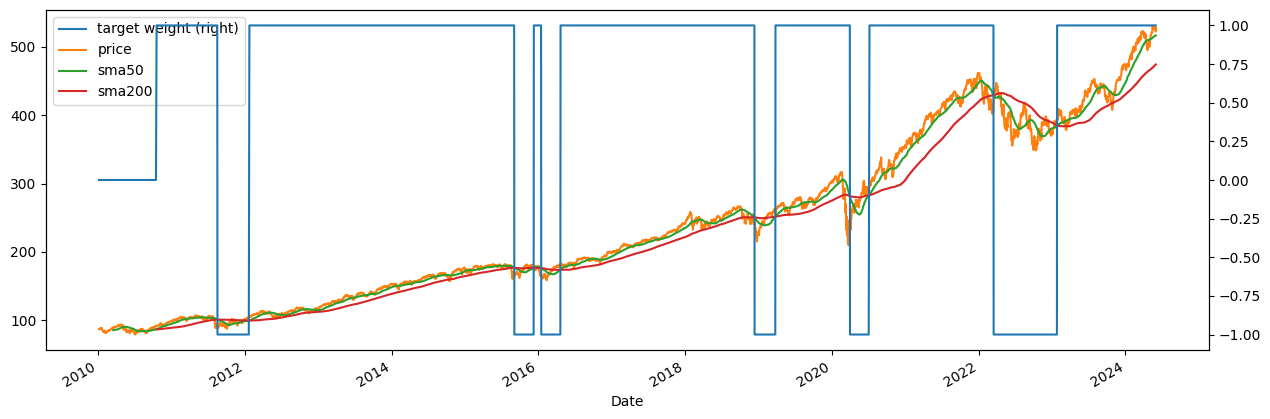

In [4]:
tmp = bt.merge(target_weight, data, sma50, sma200)
tmp.columns = ["target weight", "price", "sma50", "sma200"]
ax = tmp.plot(figsize=(15, 5), secondary_y=["target weight"]) # 왼쪽 보조축에 가중치 표시

Spy 사서 가만히 있는 것과 비교해보자

In [5]:
# 백테스트 실행
result: Result = bt.run(
    Backtest(
        Strategy("ma_cross", algos=[WeightTarget(target_weight), Rebalance()]), data
    ),
    Backtest(
        Strategy(
            "banch_mark",
            algos=[
                RunOnce(),
                SelectAll(),
                WeighEqually(),
                Rebalance(),
            ],
        ),
        data,
    ),
)

<Axes: title={'center': 'Equity Progression'}>

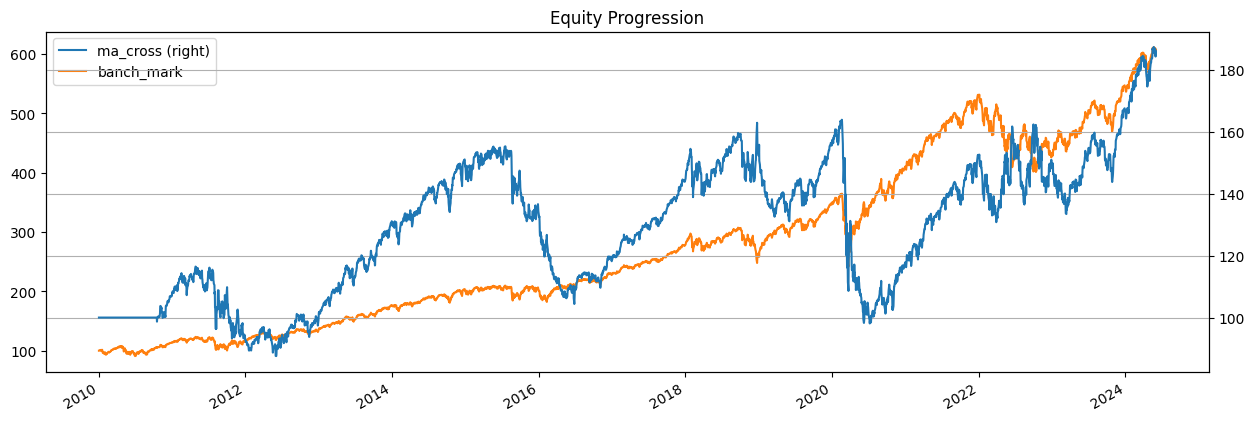

In [6]:
# 형편없는 전략인가?
result.plot(grid=True, secondary_y=["ma_cross"])